# Введение в глубинное обучение, ФКН ВШЭ

## Бонусное домашнее задание. Метод k-ближайших соседей и автокодировщики.

### Общая информация

Дата выдачи: 15.02.2022

Дедлайн сдачи: 23:59MSK 06.03.2022

Обратите внимание, что домашнее задание бонусное, поэтому для него не предусмотрен мягкий дедлайн сдачи.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 5 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании мы будем применять метод k-ближайших соседей (kNN) для классификации изображений. Идея в том, чтобы сравнить различные векторные представления изображений между собой. Будем работать с одним из самых распространенных датасетов с картинками &mdash; CIFAR10. В качестве метрики качества выберем accuracy.

In [ ]:
import torch
import random
import numpy as np

from torch import nn
from torchvision.datasets import CIFAR10

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from tqdm import tqdm

from IPython.display import clear_output

from copy import deepcopy

import matplotlib.pyplot as plt

In [ ]:
train_set = CIFAR10('CIFAR10', train=True, download=True)
test_set = CIFAR10('CIFAR10', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


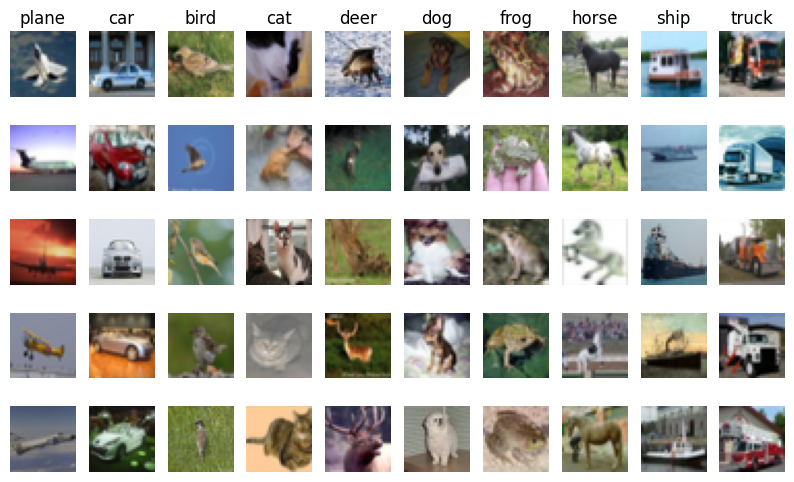

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
plt.figure(figsize=(10, 6), dpi=100)
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.array(train_set.targets) == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_set.data[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## 1. Исходные изображения (0.5 балла)

Начнем с того, что попробуем использовать сами изображения в качестве признаковых описаний (то есть вытягиваем картинки в длинный вектор). 

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
set_random_seed(111)

In [ ]:
print(train_set.data.shape, test_set.data.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
X_train = train_set.data.reshape(50000, -1)
y_train = np.array(train_set.targets)

X_test = test_set.data.reshape(10000, -1)
y_test = np.array(test_set.targets)

In [ ]:
print(X_train.shape, X_test.shape)

(50000, 3072) (10000, 3072)


In [ ]:
scaler = StandardScaler().fit(X_train) # Стандартизация данных
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.mean(axis=0), X_train.std(axis=0) # теперь все данные имеют нулевое среднее значение отклонения и единичную дисперсию

(array([ 3.10516057e-16, -8.47011350e-17,  6.89848179e-17, ...,
         1.62092562e-17, -1.77591275e-16,  1.22275523e-16]),
 array([1., 1., 1., ..., 1., 1., 1.]))

Обучите метод k-ближайших соседей из `sklearn` на картинках как на длинных векторах, подберите оптимальное число соседей по кросс-валидации. Насколько качество получилось лучше, чем у случайного прогноза?

In [ ]:
# fit and predict KNN classifier model
kn = 20
knn = KNeighborsClassifier(n_neighbors=kn, n_jobs=-1)
knn.fit(X_train, y_train)
sk_preds = knn.predict(X_test)
num_correct = np.sum(sk_preds == y_test)
accuracy = float(num_correct) / len(y_test)
print(f'{kn}-Neibor: {num_correct} / {len(y_test)} correct => accuracy = {accuracy:.2f}')

20-Neibor: 3349 / 10000 correct => accuracy = 0.33


In [ ]:
# перебор количества соседей классификатор и сравнение accuracy
ks = range(1, 30, 2)
k_to_accuracies = {}

for i, k in enumerate(ks):

    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    sk_preds = knn.predict(X_test)

    num_correct = np.sum(sk_preds == y_test)
    accuracy = float(num_correct) / len(y_test)

    k_to_accuracies[k] = accuracy

    print(f'{k}-Neibor: {num_correct} / {len(y_test)} correct => accuracy = {accuracy:.2f}')

In [ ]:
# function cross validation
def cross_validation(X_train, y_train, num_folds=5, k_neibors_min=1, k_neibors_max=10, step=1):
  
  k_neibors = range(k_neibors_min, k_neibors_max+1, step)
  
  X_train_folds = np.array_split(X_train, num_folds)
  y_train_folds = np.array_split(y_train, num_folds)
  
  k_to_accuracies = {}

  for k in k_neibors:

    print(f'{k}-Neibors:')
    k_to_accuracies[k] = []

    for num_knn in range(0, num_folds):

        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train, num_knn, 0)
        X_train = np.concatenate((temp), axis = 0)
        y_train = np.delete(y_train, num_knn, 0)
        y_train = np.concatenate((y_train), axis = 0)
        
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_train, y_train)
        sk_preds = knn.predict(X_test)

        num_correct = np.sum(sk_preds == y_test)
        accuracy = float(num_correct) / len(y_test)
        k_to_accuracies[k].append(accuracy)
        print(f'{num_knn+1} folds: {num_correct} / {len(y_test)} correct => accuracy = {accuracy:.2f}')

  return k_to_accuracies

In [ ]:
# Cross validation
dict_res = cross_validation(X_train, y_train, k_neibors_max=100, step=5)

1-Neibor:
0 folds: 2665 / 8000 correct => accuracy = 0.33
1 folds: 2707 / 8000 correct => accuracy = 0.34
2 folds: 2643 / 8000 correct => accuracy = 0.33
3 folds: 2660 / 8000 correct => accuracy = 0.33
4 folds: 2640 / 8000 correct => accuracy = 0.33
6-Neibor:
0 folds: 2676 / 8000 correct => accuracy = 0.33
1 folds: 2605 / 8000 correct => accuracy = 0.33
2 folds: 2572 / 8000 correct => accuracy = 0.32
3 folds: 2580 / 8000 correct => accuracy = 0.32
4 folds: 2588 / 8000 correct => accuracy = 0.32
11-Neibor:
0 folds: 2690 / 8000 correct => accuracy = 0.34
1 folds: 2581 / 8000 correct => accuracy = 0.32
2 folds: 2548 / 8000 correct => accuracy = 0.32
3 folds: 2582 / 8000 correct => accuracy = 0.32
4 folds: 2569 / 8000 correct => accuracy = 0.32
16-Neibor:
0 folds: 2639 / 8000 correct => accuracy = 0.33
1 folds: 2585 / 8000 correct => accuracy = 0.32
2 folds: 2518 / 8000 correct => accuracy = 0.31
3 folds: 2547 / 8000 correct => accuracy = 0.32
4 folds: 2558 / 8000 correct => accuracy = 0.3

KeyboardInterrupt: ignored

In [ ]:
# Cross validation
dict_res = cross_validation(X_train, y_train, k_neibors_max=7, step=1)

1-Neibor:
1 folds: 3371 / 10000 correct => accuracy = 0.34
2 folds: 3390 / 10000 correct => accuracy = 0.34
3 folds: 3493 / 10000 correct => accuracy = 0.35
4 folds: 3335 / 10000 correct => accuracy = 0.33
5 folds: 3411 / 10000 correct => accuracy = 0.34
2-Neibor:
1 folds: 3074 / 10000 correct => accuracy = 0.31
2 folds: 3016 / 10000 correct => accuracy = 0.30
3 folds: 3090 / 10000 correct => accuracy = 0.31
4 folds: 3006 / 10000 correct => accuracy = 0.30
5 folds: 2982 / 10000 correct => accuracy = 0.30
3-Neibor:
1 folds: 3271 / 10000 correct => accuracy = 0.33
2 folds: 3274 / 10000 correct => accuracy = 0.33
3 folds: 3291 / 10000 correct => accuracy = 0.33
4 folds: 3254 / 10000 correct => accuracy = 0.33
5 folds: 3212 / 10000 correct => accuracy = 0.32
4-Neibor:
1 folds: 3323 / 10000 correct => accuracy = 0.33
2 folds: 3308 / 10000 correct => accuracy = 0.33
3 folds: 3367 / 10000 correct => accuracy = 0.34
4 folds: 3320 / 10000 correct => accuracy = 0.33
5 folds: 3267 / 10000 correct

In [ ]:
mean_accuracy = 0
for k in sorted(dict_res):

    for accuracy in dict_res[k]:
        print(f'k = {k}, accuracy = {accuracy:.3f}')
    
    if np.array(dict_res[k]).mean() > mean_accuracy:
      mean_accuracy = np.array(dict_res[k]).mean()
      k_neibors_best = k

print(f'Best k-neibors (optimal count): {k_neibors_best} => accuracy = {mean_accuracy}')

k = 1, accuracy = 0.337
k = 1, accuracy = 0.339
k = 1, accuracy = 0.349
k = 1, accuracy = 0.334
k = 1, accuracy = 0.341
k = 2, accuracy = 0.307
k = 2, accuracy = 0.302
k = 2, accuracy = 0.309
k = 2, accuracy = 0.301
k = 2, accuracy = 0.298
k = 3, accuracy = 0.327
k = 3, accuracy = 0.327
k = 3, accuracy = 0.329
k = 3, accuracy = 0.325
k = 3, accuracy = 0.321
k = 4, accuracy = 0.332
k = 4, accuracy = 0.331
k = 4, accuracy = 0.337
k = 4, accuracy = 0.332
k = 4, accuracy = 0.327
k = 5, accuracy = 0.334
k = 5, accuracy = 0.332
k = 5, accuracy = 0.337
k = 5, accuracy = 0.331
k = 5, accuracy = 0.327
k = 6, accuracy = 0.340
k = 6, accuracy = 0.330
k = 6, accuracy = 0.333
k = 6, accuracy = 0.333
k = 6, accuracy = 0.324
Best k-neibors (optimal count): 1 => accuracy = 0.34


## 2. Предобученный классификатор (1 балл)

Теперь попробуем использовать сверточную нейросеть, предобученную на ImageNet. Выберите архитектуру из `torchvision`, которая вам по душе, и используйте выход предпоследнего слоя как признаковое описание картинки. Проще всего будет найти поле класса модели, которое отвечает за последний слой (классификационную голову) и заменить его на болванку `nn.Identity` (у вас должно получиться что-то вроде `model.classifier = nn.Identity()`). В зависимости от архитектуры название этого поля может меняться, это можно уточнить в исходниках `torchvision` (смотрите документацию `torchvision.models`).

Посчитайте эмбеддинги для обучающих и тестовых картинок, не забудьте использовать правильную трансформацию данных для ImageNet, а также перевести модель в `eval` режим. Обучите kNN для получившихся представлений (все так же с подбором гиперпараметра $k$). Прокомментируйте полученные результаты. 

In [ ]:
import numpy as np
import torch

from torch import nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18

from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = resnet18(pretrained=True, progress=True)

for param in model.parameters():
  param.requires_grad=False

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

model.classifier = nn.Identity()
model.to(device)
print('model ready')

model ready


In [ ]:
# print(model)

In [ ]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
batch_size = 100

train_set = CIFAR10(root="./data", train=True, transform=transformations, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=0)

test_set = CIFAR10(root="./data", train=False, transform=transformations, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# считаем эмбединги
outputs_train = np.array([])
outputs_test = np.array([])

model.eval()
with torch.no_grad():

  for batch_x, batch_y in tqdm(train_loader, desc='train set'):
    outputs_train = np.append(outputs_train, model(batch_x.to(device)).detach().cpu().numpy())

  for batch_x, batch_y in tqdm(test_loader, desc='test set'):
    outputs_test = np.append(outputs_test, model(batch_x.to(device)).detach().cpu().numpy())

test set: 100%|██████████| 100/100 [00:06<00:00, 15.78it/s]


In [ ]:
X_train = np.array_split(outputs_train.copy(), len(train_set.data))
y_train = np.array(train_set.targets)

X_test = np.array_split(outputs_test.copy(), len(test_set.data))
y_test = np.array(test_set.targets)

In [ ]:
# fit and predict KNN classifier model
kn = 2
knn = KNeighborsClassifier(n_neighbors=kn, n_jobs=-1)
knn.fit(X_train, y_train)
sk_preds = knn.predict(X_test)
num_correct = np.sum(sk_preds == y_test)
accuracy = float(num_correct) / len(y_test)
print(f'{kn}-Neibor: {num_correct} / {len(y_test)} correct => accuracy = {accuracy:.2f}')

2-Neibor: 4359 / 10000 correct => accuracy = 0.44


In [ ]:
# Cross validation: detection k_opts
dict_res = cross_validation(X_train, y_train, k_neibors_max=10, step=1)

1-Neibors:
1 folds: 4519 / 10000 correct => accuracy = 0.45
2 folds: 4532 / 10000 correct => accuracy = 0.45
3 folds: 4541 / 10000 correct => accuracy = 0.45
4 folds: 4560 / 10000 correct => accuracy = 0.46
5 folds: 4452 / 10000 correct => accuracy = 0.45
2-Neibors:
1 folds: 4310 / 10000 correct => accuracy = 0.43
2 folds: 4324 / 10000 correct => accuracy = 0.43
3 folds: 4287 / 10000 correct => accuracy = 0.43
4 folds: 4291 / 10000 correct => accuracy = 0.43
5 folds: 4265 / 10000 correct => accuracy = 0.43
3-Neibors:
1 folds: 4694 / 10000 correct => accuracy = 0.47
2 folds: 4690 / 10000 correct => accuracy = 0.47
3 folds: 4701 / 10000 correct => accuracy = 0.47
4 folds: 4724 / 10000 correct => accuracy = 0.47
5 folds: 4700 / 10000 correct => accuracy = 0.47
4-Neibors:
1 folds: 4857 / 10000 correct => accuracy = 0.49
2 folds: 4808 / 10000 correct => accuracy = 0.48
3 folds: 4865 / 10000 correct => accuracy = 0.49
4 folds: 4894 / 10000 correct => accuracy = 0.49
5 folds: 4835 / 10000 cor

In [ ]:
dict_res = cross_validation(X_train, y_train, k_neibors_min=10, k_neibors_max=20, step=2)

10-Neibors:
1 folds: 5237 / 10000 correct => accuracy = 0.52
2 folds: 5136 / 10000 correct => accuracy = 0.51
3 folds: 5246 / 10000 correct => accuracy = 0.52
4 folds: 5208 / 10000 correct => accuracy = 0.52
5 folds: 5147 / 10000 correct => accuracy = 0.51
12-Neibors:
1 folds: 5312 / 10000 correct => accuracy = 0.53
2 folds: 5090 / 10000 correct => accuracy = 0.51
3 folds: 5243 / 10000 correct => accuracy = 0.52
4 folds: 5211 / 10000 correct => accuracy = 0.52
5 folds: 5176 / 10000 correct => accuracy = 0.52
14-Neibors:
1 folds: 5326 / 10000 correct => accuracy = 0.53
2 folds: 5153 / 10000 correct => accuracy = 0.52
3 folds: 5277 / 10000 correct => accuracy = 0.53
4 folds: 5218 / 10000 correct => accuracy = 0.52
5 folds: 5233 / 10000 correct => accuracy = 0.52
16-Neibors:
1 folds: 5362 / 10000 correct => accuracy = 0.54
2 folds: 5220 / 10000 correct => accuracy = 0.52
3 folds: 5301 / 10000 correct => accuracy = 0.53
4 folds: 5240 / 10000 correct => accuracy = 0.52
5 folds: 5256 / 10000

In [ ]:
dict_res = cross_validation(X_train, y_train, k_neibors_min=22, k_neibors_max=30, step=2)

22-Neibors:
1 folds: 5358 / 10000 correct => accuracy = 0.54
2 folds: 5259 / 10000 correct => accuracy = 0.53
3 folds: 5340 / 10000 correct => accuracy = 0.53
4 folds: 5319 / 10000 correct => accuracy = 0.53
5 folds: 5274 / 10000 correct => accuracy = 0.53
24-Neibors:
1 folds: 5359 / 10000 correct => accuracy = 0.54
2 folds: 5243 / 10000 correct => accuracy = 0.52
3 folds: 5333 / 10000 correct => accuracy = 0.53
4 folds: 5322 / 10000 correct => accuracy = 0.53
5 folds: 5314 / 10000 correct => accuracy = 0.53
26-Neibors:
1 folds: 5366 / 10000 correct => accuracy = 0.54
2 folds: 5243 / 10000 correct => accuracy = 0.52
3 folds: 5311 / 10000 correct => accuracy = 0.53
4 folds: 5329 / 10000 correct => accuracy = 0.53
5 folds: 5313 / 10000 correct => accuracy = 0.53
28-Neibors:
1 folds: 5342 / 10000 correct => accuracy = 0.53
2 folds: 5198 / 10000 correct => accuracy = 0.52
3 folds: 5343 / 10000 correct => accuracy = 0.53
4 folds: 5333 / 10000 correct => accuracy = 0.53
5 folds: 5314 / 10000

In [ ]:
dict_res = cross_validation(X_train, y_train, k_neibors_min=23, k_neibors_max=25, step=1)

23-Neibors:
1 folds: 5353 / 10000 correct => accuracy = 0.54
2 folds: 5237 / 10000 correct => accuracy = 0.52
3 folds: 5345 / 10000 correct => accuracy = 0.53
4 folds: 5315 / 10000 correct => accuracy = 0.53
5 folds: 5284 / 10000 correct => accuracy = 0.53
24-Neibors:
1 folds: 5359 / 10000 correct => accuracy = 0.54
2 folds: 5243 / 10000 correct => accuracy = 0.52
3 folds: 5333 / 10000 correct => accuracy = 0.53
4 folds: 5322 / 10000 correct => accuracy = 0.53
5 folds: 5314 / 10000 correct => accuracy = 0.53
25-Neibors:
1 folds: 5349 / 10000 correct => accuracy = 0.53
2 folds: 5233 / 10000 correct => accuracy = 0.52
3 folds: 5328 / 10000 correct => accuracy = 0.53
4 folds: 5311 / 10000 correct => accuracy = 0.53
5 folds: 5310 / 10000 correct => accuracy = 0.53


In [ ]:
mean_accuracy = 0
for k in sorted(dict_res):

    for accuracy in dict_res[k]:
        print(f'k = {k}, accuracy = {accuracy:.3f}')
    
    if np.array(dict_res[k]).mean() > mean_accuracy:
      mean_accuracy = np.array(dict_res[k]).mean()
      k_neibors_best = k

print(f'Best k-neibors (optimal count): {k_neibors_best} => accuracy = {mean_accuracy}')

k = 23, accuracy = 0.535
k = 23, accuracy = 0.524
k = 23, accuracy = 0.534
k = 23, accuracy = 0.531
k = 23, accuracy = 0.528
k = 24, accuracy = 0.536
k = 24, accuracy = 0.524
k = 24, accuracy = 0.533
k = 24, accuracy = 0.532
k = 24, accuracy = 0.531
k = 25, accuracy = 0.535
k = 25, accuracy = 0.523
k = 25, accuracy = 0.533
k = 25, accuracy = 0.531
k = 25, accuracy = 0.531
Best k-neibors (optimal count): 24 => accuracy = 0.53142


In [ ]:
knn = KNeighborsClassifier(n_neighbors=k_neibors_best, n_jobs=-1)
knn.fit(X_train, y_train)
sk_preds = knn.predict(X_test)
num_correct = np.sum(sk_preds == y_test)
accuracy = float(num_correct) / len(y_test)
print(f'{k_neibors_best}-Neibor: {num_correct} / {len(y_test)} correct => accuracy = {accuracy:.2f}')

24-Neibor: 5367 / 10000 correct => accuracy = 0.54


In [ ]:
knn.score(X_test, y_test)

0.5367

В resnet куча сверток и пулингов, в конце fully connected слой на 1000. Мы взяли предобученный resnet18 и заморозили все слои сети. Затем заменили в нём последний слой на болванку. У свертки этой сети выходит 1000 признаков. После обучения kNN со случайным количеством лучших соседей получаем точность достаточно выше, чем на исходных ихображениях. Так, свертки внутри модели помнят все фичи умеют распознавать классы из ImageNet.

Была проведена кросс-валидация на тренировочных данных для опредления оптимального числа k-соседей. После чего предсказали на тестовой выборке с этим гиперпараметром.

Судя по результатам кросс-валидации увеличение количества лучших соседей положительно влияло на эмбедингах (точность росла), чем на исходном изображении (лучшие результаты предсказаний были при k=1, что очень смешно как по мне -_-). 

## 3. PCA (0.5 балла)

Теперь будем пробовать разные методы для понижения размерности. Начнем с простейшего &mdash; обучите PCA из `sklearn` и используйте его выход в качестве признаков для kNN. Ради чистоты эксперимента возьмите число компонент равным размерности представлений из прошлого пункта. Не забываем про подбор гиперпараметра :)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_train = train_set.data.reshape(50000, -1)
y_train = np.array(train_set.targets)

X_test = test_set.data.reshape(10000, -1)
y_test = np.array(test_set.targets)

In [ ]:
X_train.shape

(50000, 3072)

In [ ]:
pca = PCA(n_components = 1000)
XTrainPCAreduced = pca.fit_transform(X_train)
# XTestPCAreduced = pca.transform(X_test)

In [ ]:
# pca.components_.shape, pca.explained_variance_, pca.n_components_

In [ ]:
XTrainPCAreduced.shape

(50000, 1000)

In [ ]:
dict_res = cross_validation(XTrainPCAreduced, y_train, k_neibors_min=5, k_neibors_max=50, step=5)

5-Neibors:
1 folds: 3345 / 10000 correct => accuracy = 0.33
2 folds: 3320 / 10000 correct => accuracy = 0.33
3 folds: 3361 / 10000 correct => accuracy = 0.34
4 folds: 3371 / 10000 correct => accuracy = 0.34
5 folds: 3286 / 10000 correct => accuracy = 0.33
10-Neibors:
1 folds: 3371 / 10000 correct => accuracy = 0.34
2 folds: 3264 / 10000 correct => accuracy = 0.33
3 folds: 3348 / 10000 correct => accuracy = 0.33
4 folds: 3358 / 10000 correct => accuracy = 0.34
5 folds: 3248 / 10000 correct => accuracy = 0.32
15-Neibors:
1 folds: 3376 / 10000 correct => accuracy = 0.34
2 folds: 3251 / 10000 correct => accuracy = 0.33
3 folds: 3297 / 10000 correct => accuracy = 0.33
4 folds: 3285 / 10000 correct => accuracy = 0.33
5 folds: 3213 / 10000 correct => accuracy = 0.32
20-Neibors:
1 folds: 3262 / 10000 correct => accuracy = 0.33
2 folds: 3205 / 10000 correct => accuracy = 0.32
3 folds: 3254 / 10000 correct => accuracy = 0.33
4 folds: 3256 / 10000 correct => accuracy = 0.33
5 folds: 3164 / 10000 

KeyboardInterrupt: ignored

In [ ]:
dict_res = cross_validation(XTrainPCAreduced, y_train, k_neibors_min=1, k_neibors_max=3, step=1)

1-Neibors:
1 folds: 3388 / 10000 correct => accuracy = 0.34
2 folds: 3371 / 10000 correct => accuracy = 0.34
3 folds: 3492 / 10000 correct => accuracy = 0.35
4 folds: 3361 / 10000 correct => accuracy = 0.34
5 folds: 3385 / 10000 correct => accuracy = 0.34
2-Neibors:
1 folds: 3056 / 10000 correct => accuracy = 0.31
2 folds: 3040 / 10000 correct => accuracy = 0.30


KeyboardInterrupt: ignored

In [ ]:
#ОПЯТЬ ОДИН СОСЕД (k=1) ДАЕТ ЛУЧШИЙ РЕЗУЛЬТАТ
k_neibors_best = 1

In [ ]:
knn = KNeighborsClassifier(n_neighbors=k_neibors_best, n_jobs=-1)
knn.fit(X_train, y_train)
sk_preds = knn.predict(X_test)
num_correct = np.sum(sk_preds == y_test)
accuracy = float(num_correct) / len(y_test)
print(f'{k_neibors_best}-Neibor: {num_correct} / {len(y_test)} correct => accuracy = {accuracy:.3f}')

1-Neibor: 3539 / 10000 correct => accuracy = 0.354


## 4. Автокодировщик (3 балла)

Теперь обратимся к нелинейным методам понижения размерности: будем экспериментировать с автокодировщиками. Обучите две вариации модели: полносвязную и сверточную. Первая будет работать с изображениями как с длинными векторами, вторая &mdash; как полагается. Рекомендуется пользоваться шаблонами, приведенными ниже (но если они уж очень вам не нравится, то это не обязательно). Как и прежде, возьмите размерность скрытого слоя равной размеру представлений из предобученного классификатора. Обязательно рисуйте графики лосса при обучении.

Сравните, как восстанавливают изображения два автокодировщика (для этого зафиксируйте несколько тестовых картинок и нарисуйте их восстановленные версии). Сделайте выводы.

Теперь по нашему стандартному протоколу: обучаем kNN, подбираем параметр числа соседей и смотрим на качество. Получилось ли качество лучше, чем при линейном понижении размерности? А чем при использовании предобученного классификатора? Попытайтесь объяснить, почему так происходит.

In [ ]:
import torch
import random
import numpy as np

from torch import nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, TensorDataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from tqdm import tqdm

from IPython.display import clear_output

import matplotlib.pyplot as plt

#### Обучаем автоэнкодер для длинных векторов

In [ ]:
# СОЗДАДИМ СВОЮ АРХИТЕКТУРУ ПОСТРОЕНИЯ ЭНКОДЕРОВ (НЕ ВОСПОЛЬЗОВАЛИСЬ РЕКОМЕНДОВАННЫМ ^_^)

class FCAutoencoder(nn.Module):

    def __init__(self, input_size, hidden=1000):

        super(FCAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2500),
            nn.ReLU(),
            nn.Linear(2500, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1500),
            nn.ReLU(),
            nn.Linear(1500, hidden),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden, 1500),
            nn.ReLU(),
            nn.Linear(1500, 2000),
            nn.ReLU(),
            nn.Linear(2000, 2500),
            nn.ReLU(),
            nn.Linear(2500, input_size),
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def SetRandomSeed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
def calculate_loss(model, dataloader, loss_fn=nn.MSELoss(), flatten=False):

    losses = []
    for batch, labels in tqdm(dataloader, desc='testing'):

        batch = batch.to(device)
        labels = labels.to(device)
        
        if flatten:
            batch = batch.view(batch.size(0), 3*32*32)

        loss = loss_fn(batch, model(batch))
        losses.append(loss)

    return (sum(losses) / len(losses)).item()

def evaluate(losses, autoencoder, dataloader, epoch):
    losses.append(calculate_loss(autoencoder, dataloader, flatten=flatten, conditional=conditional))

def train(model, dataloader, test_dataloader, optimizer, epochs=5, flatten=False, loss_fn=nn.MSELoss(), title=None):

    optim = optimizer
    
    train_losses = []
    validation_losses = []
    
    for i in range(1, epochs+1):

        print(f'################### EPOCH №{i} ###################')
        losses = 0

        for batch, labels in tqdm(dataloader, desc='training'):

            batch = batch.to(device)
            if flatten:
                batch = batch.view(batch.size(0), 3*32*32)
            optim.zero_grad()
            loss = loss_fn(batch, model(batch))
            loss.backward()
            optim.step()
            losses += loss.item() * batch.shape[0]

        train_losses.append(losses / len(dataloader.dataset))
        evaluate(validation_losses, model, test_dataloader, i)

        if title:
            image_title = f'{title} - EPOCH {i}'
            
        _plot_(train_losses, validation_losses, i , image_title)

def _plot_(train_losses, valid_losses, epoch, title):

    clear_output()
 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    ax.plot(range(1, epoch + 1), train_losses, label='Train')
    ax.plot(range(1, epoch + 1), valid_losses, label='Valid')
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid()

    plt.show()       

In [ ]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 100

train_set = CIFAR10(root="./data", train=True, transform=transformations, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = CIFAR10(root="./data", train=False, transform=transformations, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

seed = SetRandomSeed(555)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = FCAutoencoder(32*32*3).to(device)
optim = torch.optim.Adam(model.parameters())

Files already downloaded and verified
Files already downloaded and verified


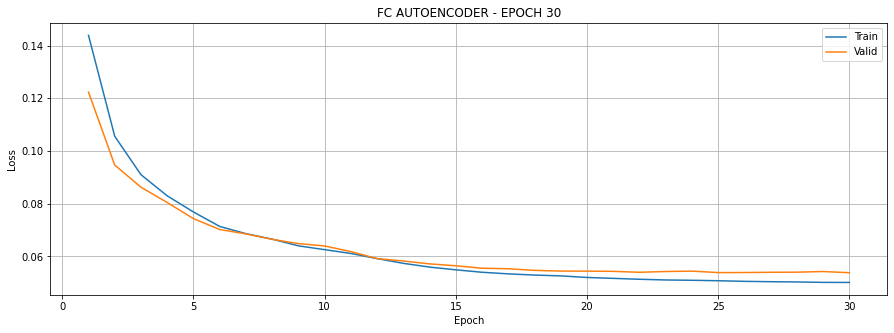

In [ ]:
train(model, train_loader, test_loader, optim, epochs=30, flatten=True, title='FC AUTOENCODER')

In [ ]:
for param in model.parameters():
  param.requires_grad=False

outputs_train = np.array([])
outputs_test = np.array([])

model.eval()
with torch.no_grad():

  for batch_x, batch_y in tqdm(train_loader, desc='train set'):
    batch_x = batch_x.reshape(batch_size, -1)
    outputs_train = np.append(outputs_train, model.encoder(batch_x.to(device)).detach().cpu().numpy())

  for batch_x, batch_y in tqdm(test_loader, desc='test set'):
    batch_x = batch_x.reshape(batch_size, -1)
    outputs_test = np.append(outputs_test, model.encoder(batch_x.to(device)).detach().cpu().numpy())

test set: 100%|██████████| 100/100 [00:04<00:00, 23.49it/s]


In [ ]:
X_train = np.array_split(outputs_train.copy(), len(train_set.data))
y_train = np.array(train_set.targets)

X_test = np.array_split(outputs_test.copy(), len(test_set.data))
y_test = np.array(test_set.targets)

In [ ]:
# Кроссвалидация для определения оптимального числа соседей модели kNN Sklearn
dict_res = cross_validation(X_train, y_train, k_neibors_min=1, k_neibors_max=50, step=5)

1-Neibors:
1 folds: 1008 / 10000 correct => accuracy = 0.10
2 folds: 1013 / 10000 correct => accuracy = 0.10
3 folds: 1053 / 10000 correct => accuracy = 0.11
4 folds: 986 / 10000 correct => accuracy = 0.10
5 folds: 989 / 10000 correct => accuracy = 0.10
6-Neibors:
1 folds: 1064 / 10000 correct => accuracy = 0.11
2 folds: 1016 / 10000 correct => accuracy = 0.10
3 folds: 1066 / 10000 correct => accuracy = 0.11
4 folds: 1006 / 10000 correct => accuracy = 0.10
5 folds: 999 / 10000 correct => accuracy = 0.10
11-Neibors:
1 folds: 974 / 10000 correct => accuracy = 0.10
2 folds: 990 / 10000 correct => accuracy = 0.10
3 folds: 1025 / 10000 correct => accuracy = 0.10
4 folds: 1029 / 10000 correct => accuracy = 0.10
5 folds: 1003 / 10000 correct => accuracy = 0.10
16-Neibors:
1 folds: 977 / 10000 correct => accuracy = 0.10
2 folds: 1015 / 10000 correct => accuracy = 0.10
3 folds: 1003 / 10000 correct => accuracy = 0.10
4 folds: 1057 / 10000 correct => accuracy = 0.11
5 folds: 967 / 10000 correct 

In [ ]:
dict_res = cross_validation(X_train, y_train, k_neibors_min=2, k_neibors_max=10, step=2)

2-Neibors:
1 folds: 1038 / 10000 correct => accuracy = 0.10
2 folds: 890 / 10000 correct => accuracy = 0.09
3 folds: 1026 / 10000 correct => accuracy = 0.10
4 folds: 990 / 10000 correct => accuracy = 0.10
5 folds: 1005 / 10000 correct => accuracy = 0.10
4-Neibors:
1 folds: 1072 / 10000 correct => accuracy = 0.11
2 folds: 985 / 10000 correct => accuracy = 0.10
3 folds: 1029 / 10000 correct => accuracy = 0.10
4 folds: 985 / 10000 correct => accuracy = 0.10
5 folds: 1027 / 10000 correct => accuracy = 0.10
6-Neibors:
1 folds: 1064 / 10000 correct => accuracy = 0.11
2 folds: 1016 / 10000 correct => accuracy = 0.10
3 folds: 1066 / 10000 correct => accuracy = 0.11
4 folds: 1006 / 10000 correct => accuracy = 0.10
5 folds: 999 / 10000 correct => accuracy = 0.10
8-Neibors:
1 folds: 1032 / 10000 correct => accuracy = 0.10
2 folds: 1018 / 10000 correct => accuracy = 0.10
3 folds: 1028 / 10000 correct => accuracy = 0.10
4 folds: 1026 / 10000 correct => accuracy = 0.10
5 folds: 1014 / 10000 correct 

In [ ]:
dict_res = cross_validation(X_train, y_train, k_neibors_min=5, k_neibors_max=7, step=1)

5-Neibors:
1 folds: 1065 / 10000 correct => accuracy = 0.11
2 folds: 998 / 10000 correct => accuracy = 0.10
3 folds: 1035 / 10000 correct => accuracy = 0.10
4 folds: 953 / 10000 correct => accuracy = 0.10
5 folds: 998 / 10000 correct => accuracy = 0.10
6-Neibors:
1 folds: 1064 / 10000 correct => accuracy = 0.11
2 folds: 1016 / 10000 correct => accuracy = 0.10
3 folds: 1066 / 10000 correct => accuracy = 0.11
4 folds: 1006 / 10000 correct => accuracy = 0.10
5 folds: 999 / 10000 correct => accuracy = 0.10
7-Neibors:
1 folds: 1026 / 10000 correct => accuracy = 0.10
2 folds: 1006 / 10000 correct => accuracy = 0.10
3 folds: 1064 / 10000 correct => accuracy = 0.11
4 folds: 1019 / 10000 correct => accuracy = 0.10
5 folds: 985 / 10000 correct => accuracy = 0.10


In [ ]:
mean_accuracy = 0
for k in sorted(dict_res):

    for accuracy in dict_res[k]:
        print(f'k = {k}, accuracy = {accuracy:.3f}')
    
    if np.array(dict_res[k]).mean() > mean_accuracy:
      mean_accuracy = np.array(dict_res[k]).mean()
      k_neibors_best = k

print(f'Best k-neibors (optimal count): {k_neibors_best} => accuracy = {mean_accuracy}')

k = 5, accuracy = 0.106
k = 5, accuracy = 0.100
k = 5, accuracy = 0.103
k = 5, accuracy = 0.095
k = 5, accuracy = 0.100
k = 6, accuracy = 0.106
k = 6, accuracy = 0.102
k = 6, accuracy = 0.107
k = 6, accuracy = 0.101
k = 6, accuracy = 0.100
k = 7, accuracy = 0.103
k = 7, accuracy = 0.101
k = 7, accuracy = 0.106
k = 7, accuracy = 0.102
k = 7, accuracy = 0.099
Best k-neibors (optimal count): 6 => accuracy = 0.10302


In [ ]:
k_neibors_best = 6

In [ ]:
knn = KNeighborsClassifier(n_neighbors=k_neibors_best, n_jobs=-1)
knn.fit(X_train, y_train)
sk_preds = knn.predict(X_test)
num_correct = np.sum(sk_preds == y_test)
accuracy = float(num_correct) / len(y_test)
print(f'{k_neibors_best}-Neibor: {num_correct} / {len(y_test)} correct => accuracy = {accuracy:.3f}')

6-Neibor: 1009 / 10000 correct => accuracy = 0.101


Точность хуже чем у предобученного классификатора и лийнейного метода понижения размерности изображения

#### Обучаем сверточный енкодер

In [ ]:
class CNNAutoencoder(nn.Module):

    def __init__(self):
      
        super(CNNAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 100

train_set = CIFAR10(root="./data", train=True, transform=transformations, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = CIFAR10(root="./data", train=False, transform=transformations, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

seed = SetRandomSeed(555)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model_CNNAutoencoder = CNNAutoencoder().to(device)
optim_CNNAutoencoder = torch.optim.Adam(model_CNNAutoencoder.parameters())

Files already downloaded and verified
Files already downloaded and verified


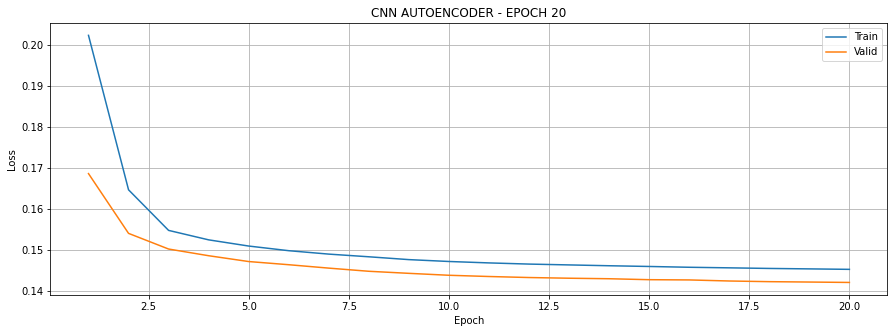

In [ ]:
train(model_CNNAutoencoder, train_loader, test_loader, optim_CNNAutoencoder, epochs=20, flatten=False, title='CNN AUTOENCODER')

In [ ]:
for param in model_CNNAutoencoder.parameters():
  param.requires_grad=False

outputs_train = np.array([])
outputs_test = np.array([])

model_CNNAutoencoder.eval()
with torch.no_grad():

  for batch_x, batch_y in tqdm(train_loader, desc='train set'):
    outputs_train = np.append(outputs_train, model_CNNAutoencoder.encoder(batch_x.to(device)).detach().cpu().numpy())

  for batch_x, batch_y in tqdm(test_loader, desc='test set'):
    outputs_test = np.append(outputs_test, model_CNNAutoencoder.encoder(batch_x.to(device)).detach().cpu().numpy())

test set: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


In [ ]:
outputs_train.shape

(38400000,)

Как восстанавливают изображения два автокодировщика ? Сравнение с исходными изображениями

In [ ]:
batch_size = 5
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
def test_image_reconstruction(model, test_loader):

     for img, trg in test_loader:

        img = img.to(device)
        img = img.view(batch_size, -1)

        outputs = model(img)
        outputs = outputs.view(batch_size, 32, 32, 3).cpu().data

        plt.figure(figsize=(10, 6), dpi=100)

        for j in range(len(img)):
          plt.subplot(2, batch_size, j + 1)
          plt.imshow(test_loader.dataset.data[j].astype('uint8'))
          plt.axis('off')

        for i in range(len(img)):
          plt.subplot(2, batch_size, j + 1 + i + 1)
          plt.imshow(outputs[i])
          plt.axis('off')

        plt.show()

        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


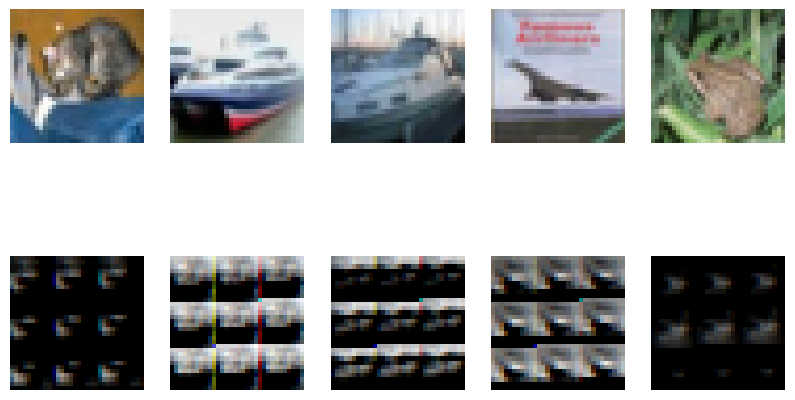

In [ ]:
# АВТОКОДИРОВКА полносвязной моделью
test_image_reconstruction(model, test_loader)

In [ ]:
# АВТОКОДИРОВКА сверточной моделью
test_image_reconstruction(model_CNNAutoencoder, test_loader)

RuntimeError: ignored